In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
from tqdm import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np
from pytorch_gan_metrics import get_inception_score_and_fid, get_inception_score, get_fid


from torchvision.models import inception_v3
from torchvision.transforms import functional as F
from PIL import Image
from scipy.linalg import sqrtm

In [4]:
# Log in to W&B account
import wandb
os.environ["WANDB_NOTEBOOK_NAME"] = "Ex6_2CelebA.ipynb"
wandb.login()

wandb: Currently logged in as: abhishek00110 (abhidgmo). Use `wandb login --relogin` to force relogin


True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 1
FEATURES_DISC = 64
FEATURES_GEN = 64

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Load the datasets
dataset = datasets.ImageFolder(root='./img_align_celeba/train', transform=transform)
# Data loaders
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)


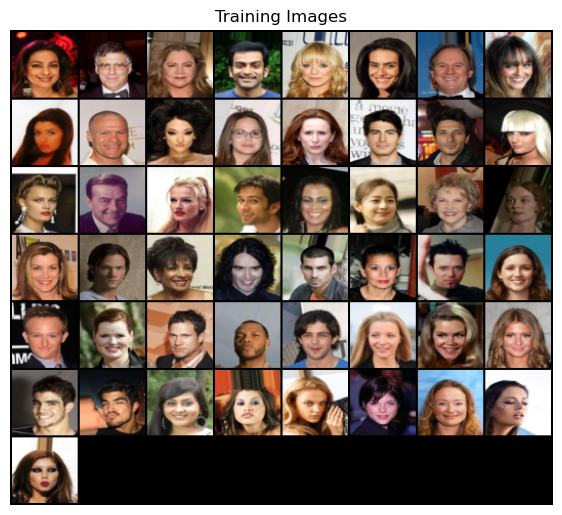

In [8]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:49], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

In [88]:
g = Generator(z_dim=100, channels_img=3, features_g=64)
print(g)

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

In [10]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [89]:
d = Discriminator(channels_img=3,features_d=32)
print(d)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)


In [11]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [28]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)

In [29]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

### Generating some of the fake images using the Training Function here

In [42]:
def show_tensor_images(image_tensor, num_images=32, size=(1, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Epoch [0/1] Batch 0/1267                   Loss D: 0.4522, loss G: 2.9386


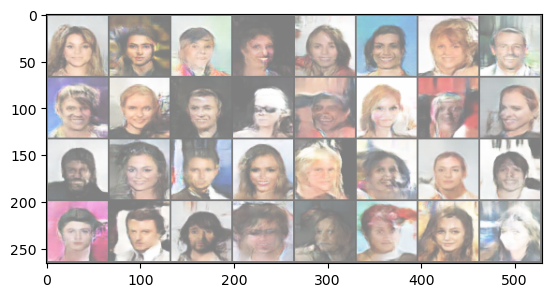

Epoch [0/1] Batch 500/1267                   Loss D: 0.3536, loss G: 6.6848


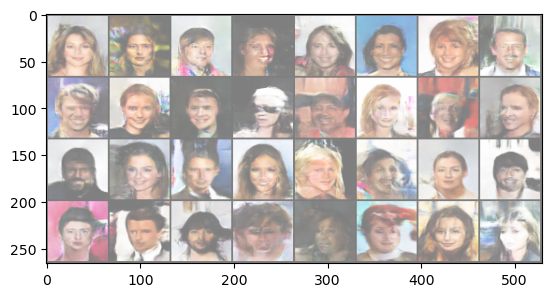

Epoch [0/1] Batch 1000/1267                   Loss D: 0.1213, loss G: 4.5888


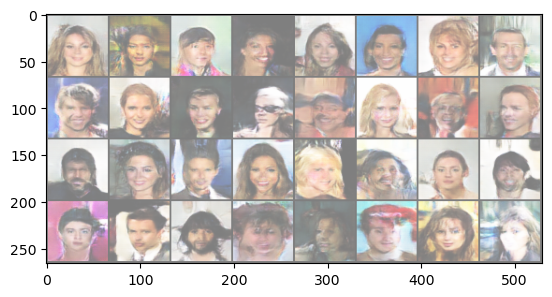

In [59]:
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _ ) in enumerate(dataloader):
        real = real.to(device)
        ### create noise tensor
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        ### Print losses occasionally and fake images occasionally
        if batch_idx % 500 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                show_tensor_images(img_grid_fake)

Interpretations:
replacing fixed_noise with random_noise we can get different fake images each time.Here we are geting the same fake images.

### To show the Logging using the WandDB

In [56]:

def train():

    gen.train()
    disc.train()
    
    # Wandb Initialization
    run = wandb.init()
    nv_size = run.config.nv_size
    run.name = f'DCGAN-{nv_size}'  # nv_size of current iteration

    for epoch in range(NUM_EPOCHS):
        for batch_idx, (real, _ ) in enumerate(dataloader):
            real = real.to(device)
            ### create noise tensor
            noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
            fake = gen(noise)

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            disc_real = disc(real).reshape(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake.detach()).reshape(-1)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            output = disc(fake).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()
            

             # Log losses and IS
            wandb.log({'Discriminator loss': loss_disc, 'Generator loss': loss_gen})#, 'FID Score': fid_score})



In [57]:
sweep_configuration = {
    'name': 'Fully Convolutional DCGAN',
    'metric': { 'name': 'Generative loss', 'goal': 'minimize' },
    'method': 'grid',
    'parameters': {
        'nv_size': {
            'values': [10, 50, 100, 200, 300, 400]
        }
    }
}
sweep_id = wandb.sweep(sweep_configuration, project='cudalab-assignment6-dcgan')

Create sweep with ID: hw36ctlh
Sweep URL: https://wandb.ai/abhidgmo/cudalab-assignment6-dcgan/sweeps/hw36ctlh


In [58]:
wandb.agent(sweep_id, function=train, project='cudalab-assignment6-dcgan')

wandb: Agent Starting Run: kk6dghy4 with config:
wandb: 	nv_size: 10


Discriminator loss,▂▂▂▄▁▃▁▂▁▂▇▂█▂▂▆▃▁▁▂▁▁▄▁▂▁▂▃▂▂▁▁▂▂▄▃▂▂▃▁
Generator loss,▄▂▂▄▃▅▃▁▄▅▆▂▄▄▄▁▄▃▃▃▄▃▅▂▃▃▂▁▃▄▁▂▃▃▃▃▃▃█▃
Discriminator loss,0.23283
Generator loss,3.77106


wandb: Agent Starting Run: qx046xau with config:
wandb: 	nv_size: 50


Discriminator loss,▄▁▁▅▂▂▆▃▃▂▁█▃▁▂▄▄▂▅▁▁▅▂▂▂▂▃▂▂▃▂▁▁▂▂▄▂▃▁█
Generator loss,▁▃▃▃▂▂▆▄▁▃▂▂▂▂▂▃▃▃▆▂▂▄▃▄▂▃▁▃▂▃▁▃▃▃▂▅▁▃▂█
Discriminator loss,0.37778
Generator loss,3.56931


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8kxpd3cf with config:
wandb: 	nv_size: 100


Discriminator loss,▅▄▂▂▂▂▂▁▂▅▂▅▅▃▁▂▂▃▁▃▃▁█▂▁▅▂▃▂▂▂▁▂▂▁▆▃▂▂▂
Generator loss,▃▇▄▅▃▃▄▅▄▂▅▁▂▆▄▅▄▅▃▂█▄▁▄▄▃▅▇▃▅▅▄▆▄▄▁▆▃▅▇
Discriminator loss,2.06415
Generator loss,1.55378


wandb: Agent Starting Run: cnzjcy4z with config:
wandb: 	nv_size: 200


Discriminator loss,▁▁▃▂▁▁▁▂▂▁█▃▁▁▁▃▁▃▂▁▁▅▂▁▁▂▁▁▃▁▂▁▁▄▂▁▂▁▁▁
Generator loss,▃▃▄▅▃▃▃▃▂▃▁▂▂▂▃▆▃▅▂▃▄▂▂▃▃▃▂▃▁▃▃▃▃█▂▃▃▂▃▄
Discriminator loss,0.08835
Generator loss,3.75063


wandb: Agent Starting Run: j9x3fteh with config:
wandb: 	nv_size: 300


Discriminator loss,█▃▂▄▄▂▇▆▂▆▄▂▄▂▂▂▃▅▂▂▂▄▅▂▂▂▁█▂▁▄▃▁▁▂▂▂▁▂▂
Generator loss,▅▅▂▁▆▄▅▇▃█▄▄▁▃▃▄▂▆▃▃▂▆▂▄▄▃▂▇▅▄▅▆▃▃▄▅▅▃▃▂
Discriminator loss,0.13967
Generator loss,3.50131


wandb: Agent Starting Run: z3z3frzl with config:
wandb: 	nv_size: 400


Discriminator loss,▂▂▂▇▄▁▂▂▂▂▁▂▂█▂▃▁▂▁▁▂▁▂▁▂▂▂▁▁▂▁▂▂▄▂▁▃▂▂▃
Generator loss,▃▅▅▁▃▅▃▃▃▃▄▃▆▁▄▆▅▃▅▄▄▅▅▄▅▃▃▃▄▄▄▄▄█▆▅▆▃▅▆
Discriminator loss,0.55153
Generator loss,6.44409


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Interpretations

In the Discriminator loss is decreasing over time but we are seeing some spikes-either better images or we think there can be some instability in the training process.

Also higher generator loss is seen in all DCGANS.it can mean the discriminator is less likely to be fooled by the fake images showing lesser improvement here.

In case of small nv_size-The Generator loss curve increases for a few steps and then gradually decreases and for the most instances stays in the same loss range. We can see that the discriminator loss as a result stays below 1 after the initial stages.Ideally loss should be as small as possible for both the generator and the discriminator..

For nv_size higher we are seeing higher Generator loss and less discriminator loss. It gives a general picture of higher input dimensionality leads to a persistent high generator loss, vanishing discriminator loss.

FID score has been earlier calculated but later dropped from wandDB beacuse of getting some errors.

FID Calcuulations. -We have extracted fake and real images into 2 folders and are calculating FID-It is show in a different notebook file beacuse we are getting an unexpected error, which we are not able to resolve due to limited time.however the code reamains the same and check the 2nd notebook file 6.2_FID to see FID calculation.

References taken: Adapataions have been learned and taken from Medium Articles.